In [1]:
import torch
import torch.nn as nn
from utils import *
from torchvision import datasets, transforms

data_dir = '../data-unversioned/p2ch10/'
metadata = {
    "image_size": 28,
    "num_classes": 10,
    "train_images": 60000,
    "val_images": 10000,
    "num_channels": 1,
}

# Get the EMNIST dataset
padding_size = (32 - metadata["image_size"]) // 2
transform_train = transforms.Compose(
    [
        transforms.Pad(padding_size),  # Add padding to make the image 32x32
        transforms.RandomResizedCrop(
            32, scale=(0.8, 1.0), ratio=(0.8, 1.2)
        ),
        transforms.ToTensor(),
    ]
)
train_set = datasets.MNIST(
    root=data_dir,
    train=True,
    download=True,
    transform=transform_train,
)

In [2]:
# Create data loaders for the training dataset
dataloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
for inputs, targets in dataloader:
    print(inputs.shape, targets.shape)
    break

torch.Size([64, 1, 32, 32]) torch.Size([64])


In [3]:
device

'cuda'

In [4]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = metadata["num_channels"]
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = metadata["num_channels"]
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalEmbedding(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))

def train(model, optimizer, num_epochs, curr_epoch=0):
    from tqdm import tqdm
    model.to(device)

    while curr_epoch < num_epochs:
        # Initialize tqdm progress bar
        with tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {curr_epoch}") as pbar:
            for step, (x, _) in pbar:
                x = x.to(device)
                model.train()
                t = torch.randint(0, T, (x.shape[0],), device=device)
                optimizer.zero_grad()
                loss = get_loss(model, x, t)
                loss.backward()
                optimizer.step()
                # Update the progress bar with the current loss
                pbar.set_postfix({'Loss': loss.item()})
        # Optionally, plot an image sample after each epoch
        curr_epoch += 1
        # sample_plot_image(model)
    return curr_epoch
curr_epoch = 0
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(model, optimizer, 1, curr_epoch=curr_epoch)

Num params:  62437601


Epoch 0: 100%|██████████| 938/938 [01:56<00:00,  8.08it/s, Loss=0.0128]


1

In [30]:
train(model, optimizer, 5, curr_epoch=curr_epoch)

Epoch 4: 100%|██████████| 938/938 [01:58<00:00,  7.93it/s, Loss=0.023]  


5

In [38]:
path = "model.pt"
torch.save(model.state_dict(), path)

In [ ]:
model.load_state_dict(torch.load(path, weights_only=True))

In [35]:
from PIL import Image
def show_tensor_image(tensor):
    # take only the first batch
    tensor = tensor[0, :, :, :] 
    # Step 1: Convert tensor to PIL Image
    unloader = transforms.ToPILImage()
    image = unloader(tensor)
    # Step 2: Resize the image to original MNIST size (28x28)
    # Note: This step won't perfectly reverse the random crop but adjusts the size
    resize = transforms.Resize((28, 28))
    image = resize(image)
    # Step 3: Since padding was added to make the image 32x32, and we resized it to 28x28,
    # we assume the padding is effectively removed by the resize. If explicit removal is needed:
    # crop = transforms.CenterCrop(28)  # This line is optional, depending on your needs
    # image = crop(image)
    plt.imshow(image)

In [36]:
@torch.no_grad()
def sample_plot_image(model):
    # Sample noise
    img_size = 32
    img = torch.randn((1, 1, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(model, img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show() 

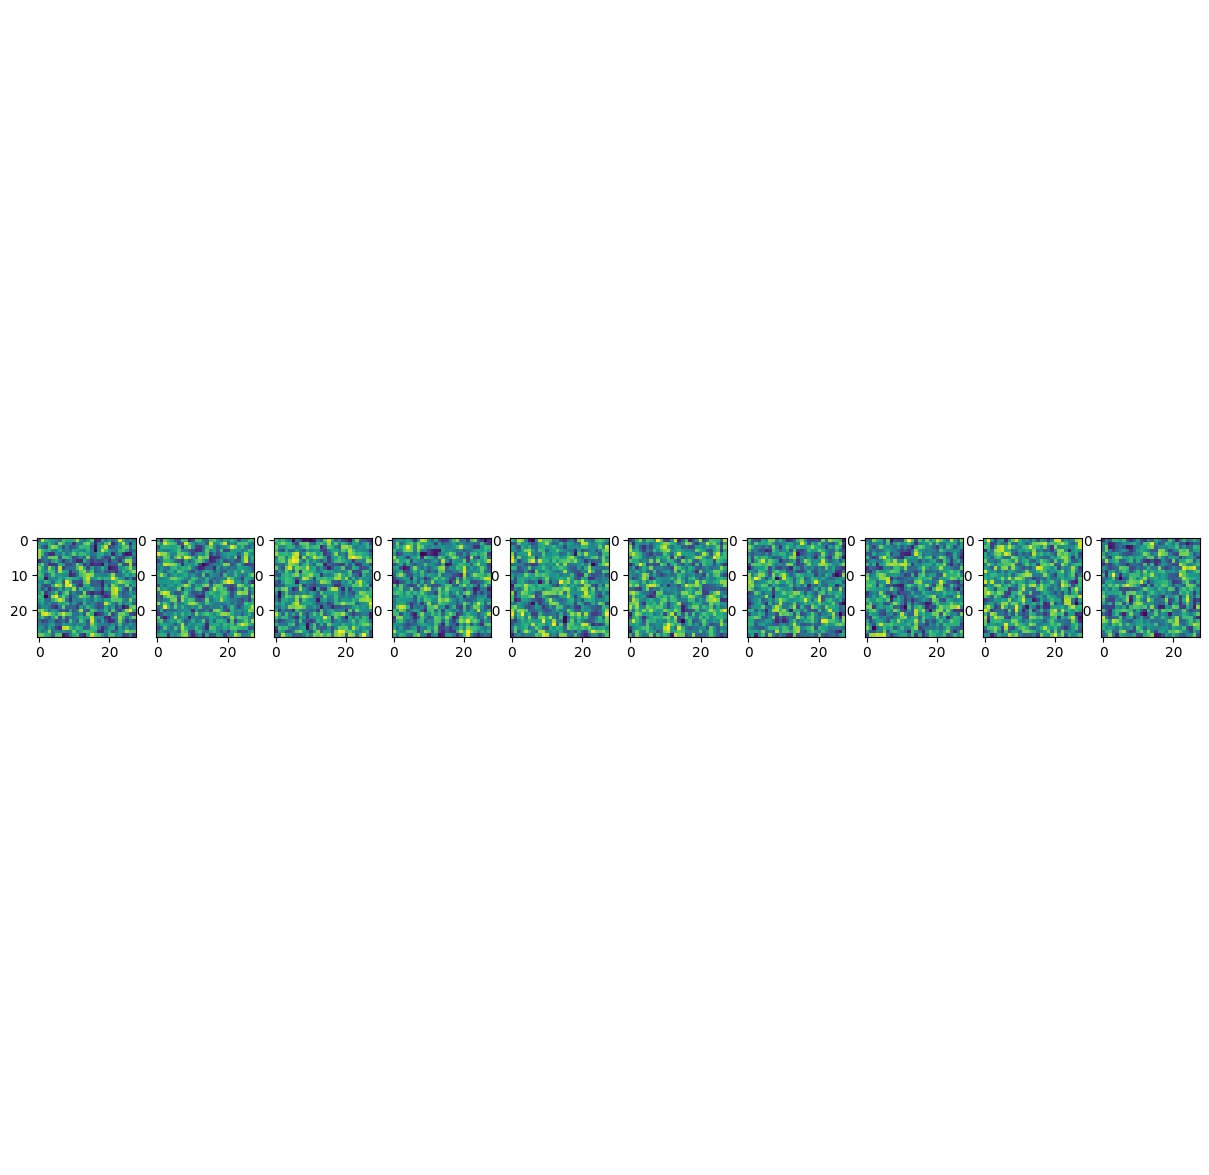

In [37]:
sample_plot_image(model)